In [1]:
from ipywidgets import interact
import ipywidgets as widgets
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [2]:
fs, p = wavfile.read('sonido-presion/presion_segmento_1.wav')
fs, y = wavfile.read('sonido-presion/y_segmento_1.wav')
fs, b = wavfile.read('sonido-presion/beta_segmento_1.wav')
fs, s_m = wavfile.read('sonido-presion/sonido_segmento_1.wav')
fs, delta = wavfile.read('sonido-presion/delta_segmento_1.wav')
fs, k = wavfile.read('sonido-presion/k_segmento_1.wav')
fs, vs = wavfile.read('sonido-presion/vs_segmento_1.wav')

In [3]:
import json
file_fon = open('sonido-presion/t_fon_segmento_1.json') 

# returns JSON object as a list 
ts_fon = json.load(file_fon) 

Este diccionario es importante porque marca los tiempos donde está prendicio delta y k. Así va hacer más fácil encotnrar la relación entre k,delta y vs

In [4]:

dt = 1/fs
N  = len(p)
t = np.arange(0, N) * dt

print(f'frec muestreo: {fs} \n dt muestreo: {dt} \n tiempo total de medición {t[-1]} s')

frec muestreo: 44150 
 dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.8827859569648924 s


In [5]:
print(len(p), len(y), len(b), len(s_m), len(delta))

38976 38976 38976 38976 38976


In [26]:
%matplotlib qt
plt.figure( figsize=(12,5))
#ploteo
colors = ['green','red','black','blue']

plt.plot(t, y/max(y),alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t, s_m/max(s_m) ,alpha = .60, color='orange', label = r'sonido')
#plt.plot(t, b, alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t, delta, alpha = .60, color=colors[2], label = r'$\delta$')
plt.plot(t, k/max(k), color = 'green', label = 'k')
plt.plot(t, np.abs(vs)/max(vs), alpha = .6, color = 'orange', label = 'vs')
#plt.plot(t, (delta_interp  + ruido) * f0, alpha = .6, color = colors[2], label = r'$\delta$')
plt.legend(loc=0)
plt.xlim(0.28,0.48)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$y(t)$', fontsize=16)
plt.show()

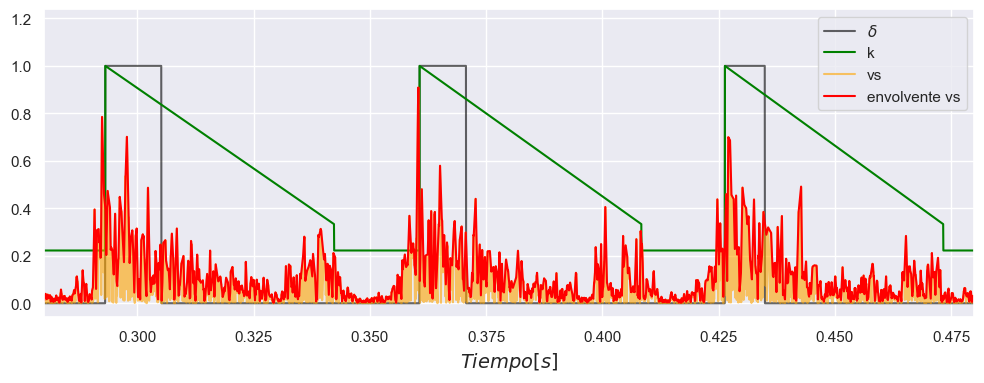

In [7]:
picos_vs, _ = signal.find_peaks(np.abs(vs), height = 0 )  

plt.figure( figsize=(12,4))
#ploteo
colors = ['green','red','black','blue']

plt.plot(t, delta, alpha = .60, color=colors[2], label = r'$\delta$')
plt.plot(t, k/max(k), color = 'green', label = 'k')
plt.plot(t, abs(vs)/max(vs), alpha = .6, color = 'orange', label = 'vs')
plt.plot(t[picos_vs], np.abs(vs[picos_vs])/max(vs), color = 'red', label = 'envolvente vs')
plt.legend(loc=0)
plt.xlim(0.28,0.48)
plt.xlabel('$Tiempo [s]$', fontsize=14)
#plt.title(r'$y(t)$', fontsize=16)
plt.show()

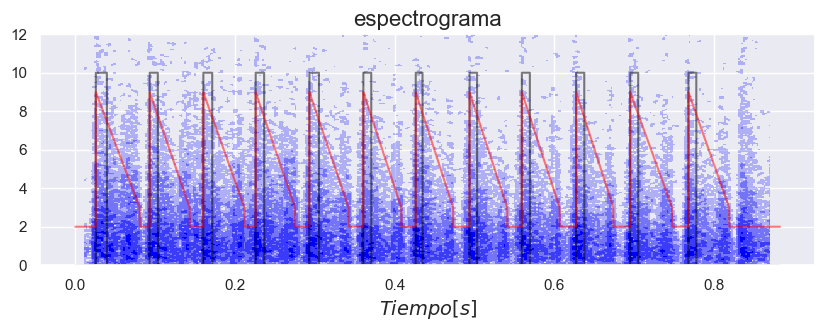

In [9]:
%matplotlib inline
#espextrograma simulacion
fu, tu, Sxx = get_spectrogram(vs, fs)
Sxx = np.clip(Sxx, a_min=np.amax(Sxx)/20000000, a_max = np.amax(Sxx))

#colormap
import matplotlib.colors as mcolors
colors = [(0,0,1,c) for c in np.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)
colors = ['green','red','black','blue']


#ploteo espectrograma
plt.figure(figsize=(10,3))
plt.pcolormesh(tu, fu/1000, np.log(Sxx), rasterized=True, shading='auto', cmap=cmapblue)
plt.plot(t,delta*10, color = 'black', alpha = .5)
plt.plot(t,k*2, color = 'red', alpha = .5)
plt.ylim(0,12)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'espectrograma', fontsize=16)
plt.show()

### Modelo Paper "From electromyographic activity to frequency modulation in zebra finch song"
Tenemos las ecuaciones dinámicas para vs:
$$
\dot{x}_1 = x_2 
$$
$$
\dot{x}_2 = - k_{vs} (x_1 - x_0(t)) - \beta_{vs} x_2
$$

Donde $x_0 (t) = \Delta_0 - \delta g(EMG))$. Siendo g la función que devuelve la envolvente del EMG.

Voy a integrar estas ecuaciones, y una vez que obtenga $x_1$ puedo calcular la fuerza que ejerce vs según:
$$
f(t) = \alpha e^{B (x_1 - x_0(t))^{-1}}
$$

Las ecuaciones CON factor de escaleo:
$$
\dot{x}_1 = x_2 
$$
$$
\dot{x}_2 = \frac{1}{\tau_2} ( -  x_2 + \frac{1}{\tau_1} (-x_1 + x_0))
$$

In [10]:

#funcion del sistema de ecuaciones
def f(X, t, params):
    x1, x2 = X
    tau1, tau2, x0 = params

    f_x1 = x2
    f_x2 = 1/tau2 * (-x2 + 1/tau1 * (-x1 + x0))
    return np.array([f_x1,f_x2])

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X


In [11]:
# la tira de tiempo de la integracion tiene mas puntos
dt_sim = dt / 20
t_sim = np.arange(0, t[-1], dt_sim)

In [12]:
#interpolo la envolvente

#info de la envolvente
t_env = t[picos_vs]
t_env = np.append(t_env,t[-1]) #le agrego el primer y ultimo valor de la tira de tiempo original asi puedo interpolar en todo el rango
t_env = np.insert(t_env,0, t[0])

vs_env = np.abs(vs[picos_vs])
vs_env = np.append(vs_env, vs[-1])
vs_env = np.insert(vs_env,0, vs[0])

interp_func = interp1d(t_env, vs_env)

vs_env_interpolada = interp_func(t_sim)


In [13]:
N_i = len(t_sim)

#parametros
x0 = 5e-3 - 4e-3 * vs_env_interpolada #slack (depende de la envolvente) -> paper
#x0 = vs_env_interpolada/ max(vs_env_interpolada)

# parametros escalados
b_vs = 1
k_vs = 1
tau1 = b_vs / k_vs
tau2 = 1 / b_vs

#condiciones iniciales
X0 = [1,0] 
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0

for j in range(N_i):
    params = [tau1, tau2 , x0[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t_sim[j], dt_sim, params, 4)
    

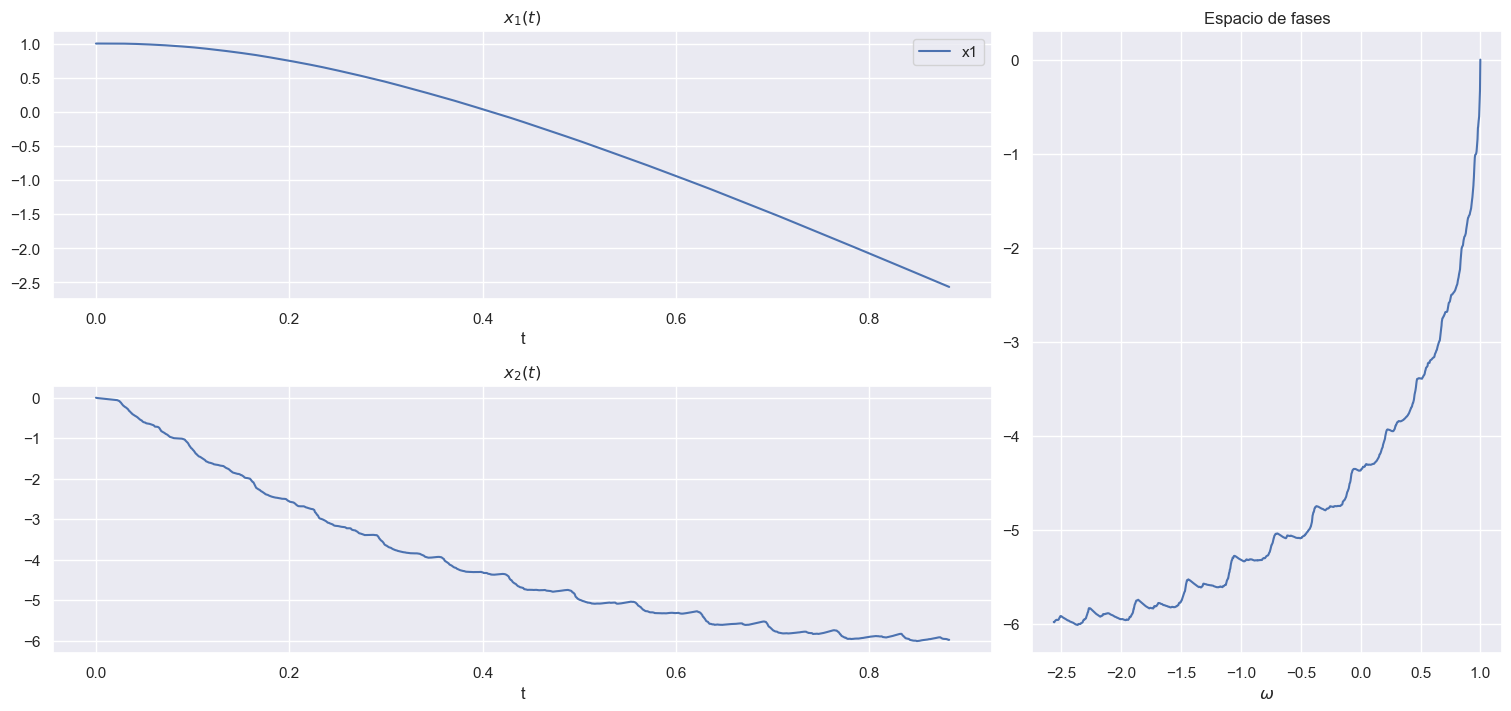

In [14]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (15,7),layout="constrained")
gs = GridSpec(2, 3, figure=fig)


ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])
ax3 = fig.add_subplot(gs[:, -1])

colors = ['green','red','black',"blue"]

#ploteo
ax1.plot(t_sim,Xs[:,0][:-1], label = 'x1')
#ax1.plot(t_sim,x0, label = 'x0')
ax1.set_title(r'$x_1(t)$')
ax1.set_xlabel('t')

ax2.plot(t_sim,Xs[:,1][:-1])
ax2.set_title(r'$x_2(t)$')
ax2.set_xlabel('t')

ax3.plot(Xs[:,0],Xs[:,1])
ax3.set_title('Espacio de fases')
ax3.set_xlabel(r'$\omega$')
ax1.legend()
plt.show()

In [15]:
def f_vs(x0,x1):
    A,B = 1,5e-2

    return A * np.exp(B * (x1-x0) - 1)

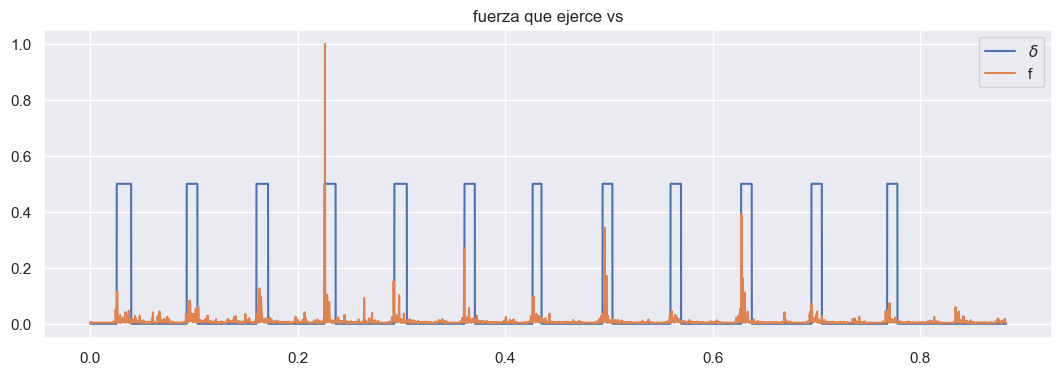

In [16]:
%matplotlib inline
fvs = f_vs(x0,Xs[:,0][:-1])
plt.figure(figsize = (13,4))
plt.title('fuerza que ejerce vs')
plt.plot(t,delta/max(delta)/2, label = r'$\delta$')
plt.plot(t_sim, fvs / max(fvs) , label = 'f')

#plt.plot(t_sim, vs_env_interpolada/ max(vs_env_interpolada), alpha = .5, label = 'env(EMG)')
plt.legend(loc  =1)
plt.show()

#### dinámica del estiramiento de los labios $x_3$

$$
\dot{x}_3 = x_4
$$
$$
\dot{x}_4 = \frac{1}{\tau_4} (-x_4 + \frac{1}{\tau_3} (-x_3 + f))
$$



In [17]:

#funcion del sistema de ecuaciones
def f(X, t, params):
    x3, x4 = X
    tau3, tau4, fvs = params

    f_x3 = x4
    f_x4 = 1/tau4 * (-x4 + 1/tau3 * (-x3 + fvs+))
    return np.array([f_x3,f_x4])

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X


In [195]:
print(len(fvs), len(t_sim))

779500 779500


In [18]:
interp_func = interp1d(t, k)

k_interp = interp_func(t_sim)

In [21]:

#parametros
# parametros escalados
b_1 = 1
k_1 = k_interp
tau3 = b_1 / k_1
tau4 = 1 / b_1

#condiciones iniciales
X0 = [1,0] 
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0

for j in range(N_i):
    params = [tau3[j], tau4 , fvs[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t_sim[j], dt_sim, params, 4)
    

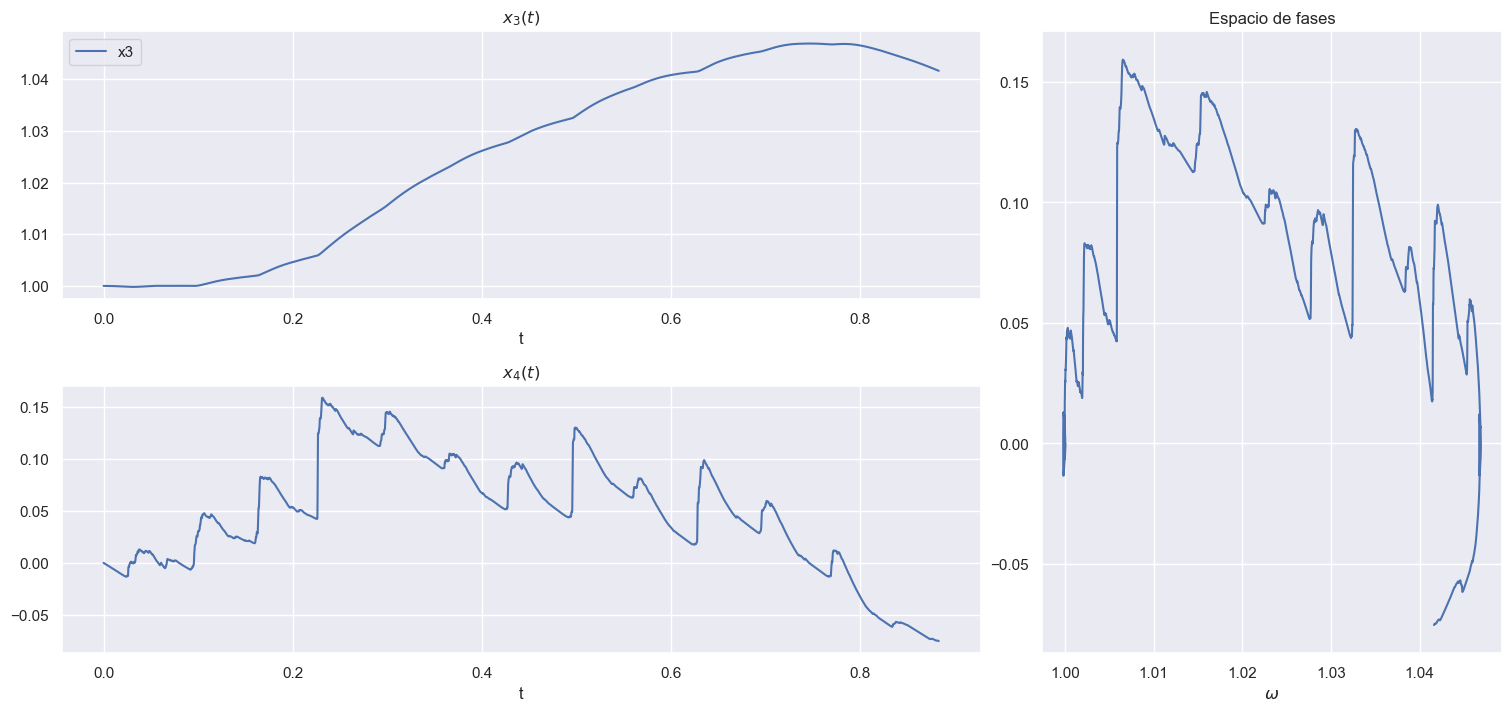

In [23]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (15,7),layout="constrained")
gs = GridSpec(2, 3, figure=fig)


ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])
ax3 = fig.add_subplot(gs[:, -1])

colors = ['green','red','black',"blue"]

#ploteo
ax1.plot(t_sim,Xs[:,0][:-1], label = 'x3')
#ax1.plot(t_sim,x0, label = 'x0')
ax1.set_title(r'$x_3(t)$')
ax1.set_xlabel('t')

ax2.plot(t_sim,Xs[:,1][:-1])
ax2.set_title(r'$x_4(t)$')
ax2.set_xlabel('t')

ax3.plot(Xs[:,0],Xs[:,1])
ax3.set_title('Espacio de fases')
ax3.set_xlabel(r'$\omega$')
ax1.legend()
plt.show()